# How to apply optimal QAOA transpilation

This tutorial shows how applying domain-specific transpilation strategies allows to reduce circuit depth and 2-qubit gate count on qaoa circuits.

## Problem setting

We'll start our workflow with a graph that represents a hypothetical max-cut problem, for example:

In [1]:
from networkx import barabasi_albert_graph, draw
graph = barabasi_albert_graph(n=10, m=6, seed=42)

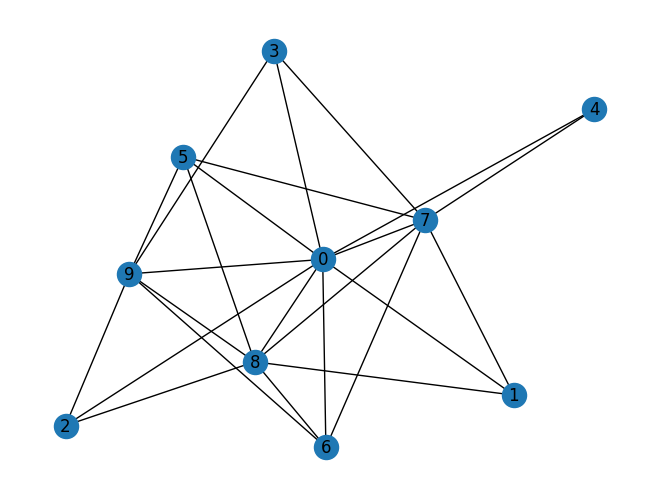

In [2]:
draw(graph, with_labels=True)

The graph above corresponds to the following operator.

In [3]:
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIZIIIIIZI', 'IZIIIIIIZI', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIZIIIZIII', 'ZIIIIIZIII', 'IIZIIZIIII', 'IIZIZIIIII', 'IZIIZIIIII', 'ZIIIZIIIII', 'IIZZIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [4]:
# import json

# graph_file = "data/graph_2layers_0seed.json"
# data = json.load(open(graph_file, "r"))

# local_correlators = data["paulis"]
# print(local_correlators)
# cost_operator = SparsePauliOp.from_list(local_correlators)

This operator maps to a 10 qubit QAOA circuit:

In [5]:
num_qubits = cost_operator.num_qubits
print(num_qubits)

10


And we'll fix the number of QAOA layers to 2 for both workflows:

In [6]:
qaoa_layers = 3

In [7]:
# Torino is too large for local simulation, 
# so instead, we generate an equivalent fake backend
# with cz gates and 19 qubits

# from qiskit_ibm_runtime.fake_provider import FakeTorino
# backend = FakeTorino()

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap.from_heavy_hex(distance=3)
print(cmap.size())
backend = GenericBackendV2(num_qubits = 19, coupling_map = cmap, basis_gates = ["x", "sx", "cz", "id", "rz"], seed=0)

19


## Naive QAOA Workflow

Build QAOA circuit/ansatz:

In [8]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector

# Initial state = equal superposition
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2*betas[0], range(num_qubits))

# Use off-the-shelf qiskit QAOAAnsatz
qaoa_ansatz = QAOAAnsatz(
    cost_operator,
    initial_state = initial_state,
    mixer_operator = mixer_operator,
    reps = qaoa_layers,
)
qaoa_ansatz.measure_all()

Transpile circuit:

In [9]:
def callback_func(**kwargs):
    pass_ = kwargs['pass_']
    print(pass_)

In [10]:
import time
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
naively_transpiled_qaoa = naive_pm.run(qaoa_ansatz) #, callback=callback_func)
t1 = time.time()

In [11]:
print(f"transpilation time: {t1 - t0} (s)")

transpilation time: 6.972665071487427 (s)


In [12]:
naively_transpiled_qaoa.count_ops()

OrderedDict([('rz', 678),
             ('sx', 638),
             ('cz', 360),
             ('measure', 10),
             ('barrier', 1)])

In [13]:
naively_transpiled_qaoa.depth()

808

## Optimal QAOA Transpilation Workflow

The optimal QAOA workflow consists on the following steps:

1. We start off by only building the cost layer of the QAOA ansatz (this is the one that contains 2q gates)
2. We transpile the cost layer applying specific swap strategies as per [REF]
3. We then build the QAOA circuit by alternating layers of transpiled cost + mixer
4. We translate the circuit to the hardware native gates and route it to the optimal qubit layout through backend evaluation as per [REF]
   
Note: We manually keep track of the qubit permutations to recover the corresponding measurements (can probably be improved)

### 1. Build cost layer

In [14]:
# We are being lazy and taking advantage of the QAOAAnsatz class
# to build the cost layer

dummy_initial_state = QuantumCircuit(num_qubits)  # the real initial state is defined later
dummy_mixer_operator = QuantumCircuit(num_qubits)  # the real mixer is defined later

cost_layer = QAOAAnsatz(
    cost_operator,
    reps=1,
    initial_state=dummy_initial_state,
    mixer_operator=dummy_mixer_operator,
    name="QAOA cost block",
)

### 2. Transpile cost layer

In [15]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
    CommutativeCancellation,
    Decompose,
    CXCancellation
)

from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)
from qiskit.circuit.library.standard_gates.equivalence_library import _sel

In [16]:
def callback_func(**kwargs):
    pass_ = kwargs['pass_']
    property_set = kwargs['property_set']
    print(pass_)

In [17]:
from qiskit.circuit.library import PauliEvolutionGate

# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}


# 2. define pass manager for cost layer
pm_pre = PassManager(
    [   
        Decompose(),
        FindCommutingPauliEvolutions(),
        Commuting2qGateRouter(
            swap_strategy,
            edge_coloring,
        ),
        Decompose(),
        Decompose(),
        CXCancellation(),
    ]
)

# 3. run pass manager for cost layer
t0_pre = time.time()
swapped_cost_layer = pm_pre.run(cost_layer, callback=callback_func)
t1_pre = time.time()
print(f"transpilation time: {t1_pre - t0_pre} (s)")

transpilation time: 0.190673828125 (s)


In [18]:
swapped_cost_layer.count_ops()

OrderedDict([('cx', 114), ('rz', 24)])

### 3. Build QAOA Ansatz

In [19]:
# We now proceed to build the QAOA ansatz using the swapped cost layer
def build_optimal_qaoa_ansatz(num_qubits, qaoa_layers, swapped_cost_layer):

    qaoa_circuit = QuantumCircuit(num_qubits, num_qubits)
    
    # Add initial state -> equal superposition
    qaoa_circuit.h(range(num_qubits))
    
    # Re-parametrize the circuit
    gammas = ParameterVector("γ", qaoa_layers)
    betas = ParameterVector("β", qaoa_layers)
    
    # Define mixer layer
    mixer_layer = QuantumCircuit(num_qubits)
    mixer_layer.rx(-2*betas[0], range(num_qubits))
    
    # iterate over number of qaoa layers
    # and alternate cost/reversed cost and mixer
    for layer in range(qaoa_layers): 
    
        bind_dict = {cost_layer.parameters[0]: gammas[layer]}
        bound_swapped_cost_layer = swapped_cost_layer.assign_parameters(bind_dict)
        
        bind_dict = {mixer_layer.parameters[0]: betas[layer]}
        bound_mixer_layer = mixer_layer.assign_parameters(bind_dict)
    
        if layer % 2 == 0:
            # even layer -> append cost
            qaoa_circuit.compose(bound_swapped_cost_layer, range(num_qubits), inplace=True)
        else:
            # odd layer -> append reversed cost
            qaoa_circuit.compose(bound_swapped_cost_layer.reverse_ops(), range(num_qubits), inplace=True)
    
        # the mixer layer is not reversed
        qaoa_circuit.compose(bound_mixer_layer, range(num_qubits), inplace=True)
    
    # qaoa_circuit.barrier()
    
    if qaoa_layers % 2 == 1:
        # iterate over layout permutations to recover measurements
        for qidx,cidx in enumerate(swapped_cost_layer.layout.initial_index_layout()):
            qaoa_circuit.measure(qidx, cidx)
    else:
        for idx in range(num_qubits):
            qaoa_circuit.measure(idx, idx)

    return qaoa_circuit
    # qaoa_circuit.draw("mpl")

In [20]:
qaoa_circuit = build_optimal_qaoa_ansatz(num_qubits, qaoa_layers, swapped_cost_layer)

### 4. Full circuit transpilation: Unroll gates and route to backend

In [21]:
from qopt_best_practices.qubit_selection import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)

In [22]:
from qiskit.transpiler import Layout

# We use the obtained path to define the initial layout
initial_layout = Layout.from_intlist(path, qaoa_circuit.qregs[0])  # needs qaoa_circ

In [23]:
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
    SabreLayout
)

pm_post = PassManager(
    [        
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names),
        BasisTranslator(_sel, target_basis=backend.operation_names),
        CommutativeCancellation(target=backend.target),
        SetLayout(initial_layout),
        FullAncillaAllocation(backend.target),
        EnlargeWithAncilla(),
        ApplyLayout(),
        CommutativeCancellation(target=backend.target)
        # SabreLayout(CouplingMap(backend.coupling_map), seed=0, swap_trials=32, layout_trials=32),
    ]
)

t0_post = time.time()
optimally_transpiled_qaoa = pm_post.run(qaoa_circuit)
t1_post = time.time()
print(f"transpilation time: {t1_post - t0_post} (s)")

transpilation time: 0.554602861404419 (s)


In [24]:
# from qiskit.converters import circuit_to_dag
# from qiskit.transpiler.passes import SabreLayout

# dag = circuit_to_dag(qaoa_circuit)
# pass_ = SabreLayout(CouplingMap(backend.coupling_map), seed=0, swap_trials=32, layout_trials=32)
# t0_test = time.time()
# pass_.run(dag)
# print(time.time()-t0_test)

## Comparison between naive and optimal

In [25]:
naive_count = naively_transpiled_qaoa.count_ops().get("cz", 0)
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)

print(f"2q gate count for naive circuit = {naive_count}")
print(f"2q gate count for optimal circuit = {optimal_count}")

2q gate count for naive circuit = 360
2q gate count for optimal circuit = 342


In [26]:
naive_2q_depth = naively_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
optimal_2q_depth = optimally_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")

print(f"2q depth for naive circuit = {naive_2q_depth}")
print(f"2q depth for optimal circuit = {optimal_2q_depth}")

2q depth for naive circuit = 224
2q depth for optimal circuit = 84


In [27]:
naive_depth = naively_transpiled_qaoa.depth()
optimal_depth = optimally_transpiled_qaoa.depth()

print(f"total depth for naive circuit = {naive_depth}")
print(f"total depth for optimal circuit = {optimal_depth}")

total depth for naive circuit = 808
total depth for optimal circuit = 340


In [28]:
time_naive = t1 - t0
time_optimal = (t1_pre - t0_pre) + (t1_post - t0_post)

print(f"total time for naive transpilation = {time_naive} (s)")
print(f"total time for optimal transpilation = {time_optimal} (s)")

total time for naive transpilation = 6.972665071487427 (s)
total time for optimal transpilation = 0.745276689529419 (s)


In [29]:
# optimally_transpiled_qaoa.draw(fold=-1)

In [30]:
# naively_transpiled_qaoa.draw(fold=-1)

## Sampler in simulation

Let's check that the distributions obtained from both circuits are equivalent:

In [31]:
naively_transpiled_qaoa.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2])])

In [32]:
optimally_transpiled_qaoa.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2])])

In [33]:
param_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

In [34]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [35]:
# result_naive = sampler.run(naively_transpiled_qaoa, param_values).result()

In [36]:
# result_optimal= sampler.run(optimally_transpiled_qaoa, param_values).result()

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(final_distribution):
    matplotlib.rcParams.update({"font.size": 10})
    final_bits = final_distribution.binary_probabilities()
    values = np.abs(list(final_bits.values()))
    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45, fontsize=3)
    plt.title("Result Distribution")
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:blue")
    plt.show()

In [38]:
# plot_distribution(result_naive.quasi_dists[0])

In [39]:
# plot_distribution(result_optimal.quasi_dists[0])

In [40]:
i_want_to_stop_here = True

if i_want_to_stop_here:
    raise UserWarning("I want the notebook to stop here")

UserWarning: I want the notebook to stop here

# Let's scale it up to 100Q

In [ ]:
graph_utility = barabasi_albert_graph(n=133, m=3, seed=42)

In [ ]:
draw(graph_utility, with_labels=True)

In [ ]:
local_correlators = build_max_cut_paulis(graph_utility)
cost_operator = SparsePauliOp.from_list(local_correlators)

In [ ]:
num_qubits = cost_operator.num_qubits
qaoa_layers = 2

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeTorino
backend = FakeTorino()

## Naive QAOA

In [ ]:
# Initial state = equal superposition
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2*betas[0], range(num_qubits))

# Use off-the-shelf qiskit QAOAAnsatz
qaoa_ansatz = QAOAAnsatz(
    cost_operator,
    initial_state = initial_state,
    mixer_operator = mixer_operator,
    reps = qaoa_layers,
)
qaoa_ansatz.measure_all()

In [ ]:
naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
naively_transpiled_qaoa = naive_pm.run(qaoa_ansatz)
t1 = time.time()
print(f"transpilation time: {t1 - t0} (s)")

In [ ]:
ops = naively_transpiled_qaoa.count_ops()
print(ops)

In [ ]:
depth = naively_transpiled_qaoa.depth()
print(depth)

In [ ]:
import json
data = {
    "method": "Naive",
    "time": t1-t0,
    "ops": ops,
    "depth": depth,
}

with open(f"data/naive_transpilation.json", "w") as file:
    json.dump(data, file)

## Optimal QAOA

In [ ]:
# We are being lazy and taking advantage of the QAOAAnsatz class
# to build the cost layer

dummy_initial_state = QuantumCircuit(num_qubits)  # the real initial state is defined later
dummy_mixer_operator = QuantumCircuit(num_qubits)  # the real mixer is defined later

cost_layer = QAOAAnsatz(
    cost_operator,
    reps=1,
    initial_state=dummy_initial_state,
    mixer_operator=dummy_mixer_operator,
    name="QAOA cost block",
)

In [ ]:
cost_layer.decompose(reps=3).count_ops()

In [ ]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# 2. define Pass manager for cost layer

pm_pre = PassManager(
    [   
        Decompose(),
        FindCommutingPauliEvolutions(),
        Commuting2qGateRouter(
            swap_strategy,
            edge_coloring,
        ),        
    ]
)

# 3. run pass manager for cost layer
t0_pre = time.time()
swapped_cost_layer = pm_pre.run(cost_layer, callback=callback_func)
t1_pre = time.time()
print(f"transpilation time: {t1_pre - t0_pre} (s)")

In [ ]:
swapped_cost_layer.count_ops()

In [ ]:
qaoa_circuit = build_optimal_qaoa_ansatz(num_qubits, qaoa_layers, swapped_cost_layer)

In [ ]:
# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
path_finder = BackendEvaluator(backend)
t0_eval = time.time()
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)
t1_eval = time.time()
print(f"backend evaluation time: {t1_eval - t0_eval} (s)")
initial_layout = Layout.from_intlist(path, qaoa_circuit.qregs[0]) 

In [ ]:
pm_post = PassManager(
    [        
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names),
        BasisTranslator(_sel, target_basis=backend.operation_names),
        CommutativeCancellation(target=backend.target),
        # SetLayout(initial_layout),
        # FullAncillaAllocation(backend.target),
        # EnlargeWithAncilla(),
        # ApplyLayout(),
        SabreLayout(CouplingMap(backend.coupling_map), seed=0, swap_trials=32, layout_trials=32),
        CommutativeCancellation(target=backend.target)
    ]
)

t0_post = time.time()
optimally_transpiled_qaoa = pm_post.run(qaoa_circuit)
t1_post = time.time()
print(f"transpilation time: {t1_post - t0_post} (s)")

In [ ]:
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)
print(f"2q gate count for optimal circuit = {optimal_count} \n")

optimal_2q_depth = optimally_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
print(f"2q depth for optimal circuit = {optimal_2q_depth} \n")

optimal_depth = optimally_transpiled_qaoa.depth()
print(f"total depth for optimal circuit = {optimal_depth} \n")

time_optimal = (t1_pre - t0_pre) + (t1_post - t0_post)
print(f"total time for optimal transpilation = {time_optimal} (s)")

## Comparison between naive and optimal

In [ ]:
naive_count = naively_transpiled_qaoa.count_ops().get("cz", 0)
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)

print(f"2q gate count for naive circuit = {naive_count}")
print(f"2q gate count for optimal circuit = {optimal_count} \n")

naive_2q_depth = naively_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
optimal_2q_depth = optimally_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")

print(f"2q depth for naive circuit = {naive_2q_depth}")
print(f"2q depth for optimal circuit = {optimal_2q_depth} \n")

naive_depth = naively_transpiled_qaoa.depth()
optimal_depth = optimally_transpiled_qaoa.depth()

print(f"total depth for naive circuit = {naive_depth}")
print(f"total depth for optimal circuit = {optimal_depth} \n")

time_naive = t1 - t0
time_optimal = (t1_pre - t0_pre) + (t1_post - t0_post)

print(f"total time for naive transpilation = {time_naive} (s)")
print(f"total time for optimal transpilation = {time_optimal} (s)")